In [18]:
import scanpy as sc
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
from scipy.stats import pearsonr
from adjustText import adjust_text
import sys
import os
sys.path.append(os.path.abspath('../'))
from DE_analysis_utils import get_DE_results_long

In [19]:
datadir = '../../../../3_expts/processed_data'
adata_de = ad.read_h5ad(datadir + '/CD4i_final/DE_results_all_confounders/CD4i_final.merged_DE_results_corrected.h5ad', backed=False)
de_by_guide = pd.read_csv('./results/DE_by_guide.correlation_results.csv', index_col=0)
donor_robustness_summary = pd.read_csv('./results/Stim8hr_debyguidegenes_donor_robustness_summary.csv', index_col=0)
de_donor_robustness = ad.read_h5ad(datadir + '/CD4i_final/CD4i_final.DE_donor_robustness.h5ad', backed=False)

In [16]:
de_by_guide[de_by_guide['target']=='CCNC']

,target,correlation,correlation_ceiling,n_signif,culture_condition
111,CCNC,0.323594,0.507852,813,Rest
1086,CCNC,0.260627,NaN,595,Stim8hr
2200,CCNC,0.416983,0.309364,1970,Stim48hr


In [15]:
adata_de[adata_de.obs.target_contrast_gene_name=='CCNC', adata_de.var.gene_name=='IL22'].layers['adj_p_value']

ArrayView([[2.38924914e-05],
           [6.01242325e-03],
           [5.19414200e-06]])

In [9]:
adata_de[adata_de.obs.target_contrast_gene_name=='', adata_de.var.gene_name=='IFNG'].obs

,target_contrast_gene_name,culture_condition,target_contrast,chunk,n_cells_target,target_contrast_corrected,target_contrast_gene_name_corrected
ENSG00000175354_Stim48hr,PTPN2,Stim48hr,ENSG00000175354,36,222.0,ENSG00000175354,PTPN2
ENSG00000175354_Rest,PTPN2,Rest,ENSG00000175354,323,288.0,ENSG00000175354,PTPN2
ENSG00000175354_Stim8hr,PTPN2,Stim8hr,ENSG00000175354,395,278.0,ENSG00000175354,PTPN2


In [3]:
de_donor_robustness.layers['zscore'] = de_donor_robustness.layers['log_fc'] / de_donor_robustness.layers['lfcSE']
de_donor_robustness.layers['zscore'][np.where(de_donor_robustness.layers['zscore'] > 50)] = 50
de_donor_robustness.X = np.nan_to_num(de_donor_robustness.layers['zscore'], 0)

In [12]:
de_donor_robustness = de_donor_robustness[de_donor_robustness.obs.culture_condition=='Stim8hr'].copy()

In [13]:
reg_all = ['MEN1', 'ELOB', 'FBRS', 'SGF29', 'ATP2A2', 'MED24', 'GATA3', 'CYB5R4', 'STAT3', 'APC', 'NFKB2', 'ATXN7L3', 'ELP2', 'PPCS', 'CCNC']
gene = ['IL22']

In [14]:
donor_pairs = de_donor_robustness.obs['donor_pair'].unique()

In [15]:
df_reg_gene = pd.DataFrame()
for donor_pair in donor_pairs:
    temp_df = get_DE_results_long(de_donor_robustness[de_donor_robustness.obs['donor_pair']==donor_pair], targets=de_donor_robustness.obs['target_contrast_gene_name'].tolist(), genes = gene)
    temp_df['donor_pair'] = donor_pair
    df_reg_gene = pd.concat([df_reg_gene, temp_df])
df_reg_gene = df_reg_gene.reset_index(drop=True)

/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_66609/1968415089.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plt.plot(np.sort(df_reg_gene.groupby('target_contrast_gene_name')['zscore'].std()/df_reg_gene.groupby('target_contrast_gene_name')['zscore'].mean()), '.')


(-10.0, 10.0)

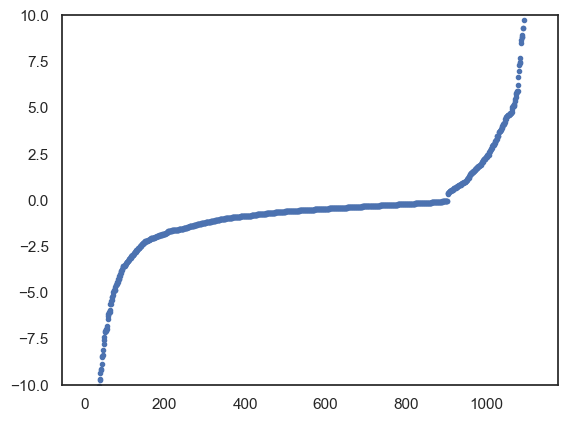

In [16]:
plt.plot(np.sort(df_reg_gene.groupby('target_contrast_gene_name')['zscore'].std()/df_reg_gene.groupby('target_contrast_gene_name')['zscore'].mean()), '.')
plt.ylim([-10,10])

### Set coefficient of variation < 1

In [24]:
reg = 'HNRNPA2B1'
df_reg_gene[df_reg_gene['target_contrast_gene_name']==reg].zscore.std()/df_reg_gene[df_reg_gene['target_contrast_gene_name']==reg].zscore.mean()

1.7479350214951164

In [39]:
target_gene_list = set(de_by_guide[(de_by_guide['culture_condition']=='Stim8hr')&(de_by_guide['correlation']>0.2)]['target'])
target_gene_list = target_gene_list & set(donor_robustness_summary[donor_robustness_summary['donor_correlation_min']>0.1]['target_name'])
target_gene_list = list(target_gene_list)

In [40]:
keep = (adata_de.obs['culture_condition']=='Stim8hr') & (adata_de.obs['target_contrast_gene_name'].isin(target_gene_list))
adata_de_filtered = adata_de[keep].to_memory()
#adata_de_filtered = adata_de.to_memory()

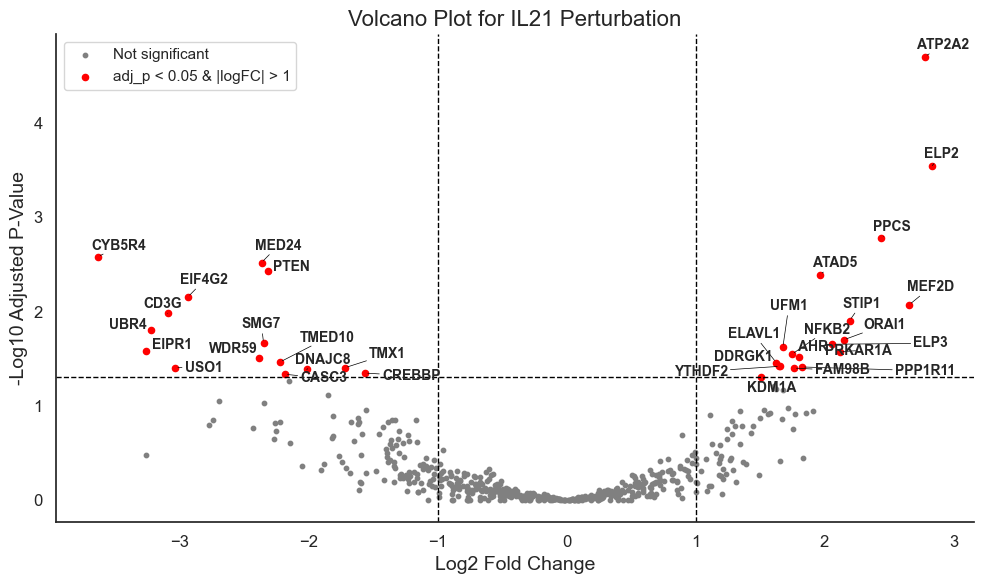

In [42]:
target_gene = 'IL4'
adj_p_thres = 0.05
log_fc_thres = 1

target_idx = np.where(adata_de_filtered.var['gene_name'] == target_gene)[0][0]
log_fc = adata_de_filtered[:, target_idx].layers['log_fc'][:, 0]
adj_pvals = adata_de_filtered[:, target_idx].layers['adj_p_value'][:, 0]

log_fc = log_fc.toarray().flatten()
adj_pvals = adj_pvals.toarray().flatten()l0gene_names = adata_de_filtered.obs.loc[:, 'target_contrast_gene_name_corrected'].values
neg_log10_pval = -np.log10(np.clip(adj_pvals, 1e-300, 1))

# Step 4: Significance mask
is_signif = (adj_pvals < adj_p_thres) & (np.abs(log_fc) > log_fc_thres)
sig_log_fc = log_fc[is_signif]
sig_pval = adj_pvals[is_signif]
sig_names = gene_names[is_signif]
sig_neglogp = neg_log10_pval[is_signif]

# Step 5: Get top N significant genes
top_n = 20
left_mask = sig_log_fc < 0
left_idx = np.argsort(-sig_neglogp[left_mask])[:top_n]
left_genes = sig_names[left_mask][left_idx]
right_mask = sig_log_fc > 0
right_idx = np.argsort(-sig_neglogp[right_mask])[:top_n]
right_genes = sig_names[right_mask][right_idx]
annot_genes = np.concatenate([left_genes, right_genes])

# Step 6: Plot
sns.set(style="white")
plt.figure(figsize=(10, 6))
plt.scatter(log_fc, neg_log10_pval, c='grey', s=10, label='Not significant')
plt.scatter(log_fc[is_signif], neg_log10_pval[is_signif], c='red', s=20, label=f'adj_p < {adj_p_thres} & |logFC| > {log_fc_thres}')

# Labels
texts = []
for gene in annot_genes:
    idx = np.where(sig_names == gene)[0][0]
    texts.append(
        plt.text(sig_log_fc[idx], sig_neglogp[idx], gene,
                 fontsize=10, weight='bold', ha='center', va='bottom')
    )

# Adjust to avoid collisions
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='black', lw=0.5))

# Reference lines
plt.axvline(-log_fc_thres, color='black', linestyle='--', linewidth=1)
plt.axvline(log_fc_thres, color='black', linestyle='--', linewidth=1)
plt.axhline(-np.log10(adj_p_thres), color='black', linestyle='--', linewidth=1)

# Labels and formatting
plt.xlabel('Log2 Fold Change', fontsize=14)
plt.ylabel('-Log10 Adjusted P-Value', fontsize=14)
plt.title(f'Volcano Plot for {target_gene} Perturbation', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()
sns.despine()
plt.tight_layout()
plt.show()

In [28]:
annot_genes = ['MEN1', 'ELOB', 'FBRS', 'SGF29', 'ATP2A2', 'MED24', 'GATA3', 'CYB5R4', 'STAT3'] # 'ATXN7L3', 'ELP2', 'PPCS']

In [92]:
summary_df.loc[['TBX21','GATA3','CFAP298','SORL1','PTPN2','POLE3','MEN1',
                'ARRDC4','CYB5R4','SFXN1','ELOB','ZNF74','ATP2A2','CCNC','TMED9'], 'IFNG_flowlfc'] = np.log([0.236682951,1.115685095,0.707111303,
                                                                                                             0.808116441,1.340527288,1.066418252,
                                                                                                             1.625631301,1.35879521,0.330350345,
                                                                                                             0.829940691,1.253849169,0.877373787,
                                                                                                             1.049694857,1.373313557,1.652605838])

In [93]:
annotations = summary_df[['zscore_IFNG', 'IFNG_flowlfc']].astype(str)
for i in range(len(df)):
    if summary_df['padj_IFNG'].iloc[i] < 0.05:
        annotations.iloc[i, 0] = f"{summary_df['padj_IFNG'].iloc[i]:.2e}"
        annotations.iloc[i, 1] = f""
    else:
        annotations.iloc[i, 0] = f""
        annotations.iloc[i, 1] = f""

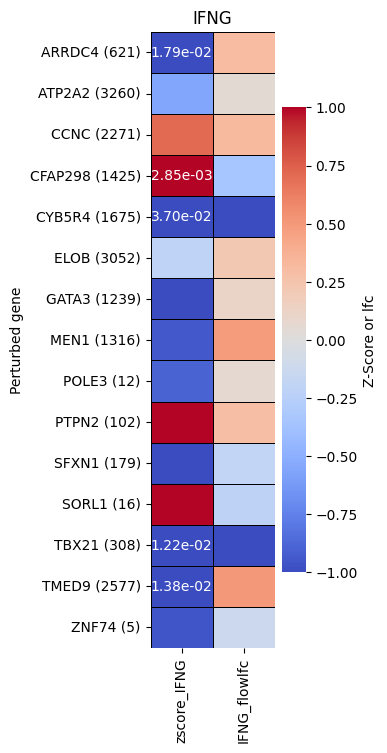

In [95]:
# Plot the heatmap
plt.figure(figsize=(2, 8))
sns.heatmap(
    summary_df[['zscore_IFNG', 'IFNG_flowlfc']],
    annot=annotations,
    fmt="",
    cmap='coolwarm',
    cbar_kws={'label': 'Z-Score or lfc'},
    linewidths=0.5,
    linecolor='black',
    yticklabels=[gene+f' ({nde})' for gene, nde in zip(summary_df.index,summary_df.n_total_de_genes)],
    vmin=-1,
    vmax=1
)
plt.title('IFNG')
plt.ylabel('Perturbed gene')
plt.yticks(rotation=0)
plt.show()

### Pick state regulators

In [108]:
polarization_coefficient = pd.read_csv('../4_polarization_signatures/results/polarization_prediction_condition_comparison.regulator_coefficients.csv', index_col=0)

In [133]:
test = polarization_coefficient[(polarization_coefficient['signature']=='ota')&(polarization_coefficient['celltype']=='Stim8hr')].copy()

In [132]:
de_by_guide

,target,correlation,correlation_ceiling,n_signif,culture_condition
0,A2M,-0.466086,NaN,10,Rest
1,ABCC1,0.084480,NaN,84,Rest
2,ABHD12,0.490760,0.628502,360,Rest
3,ABHD13,-0.301527,0.527995,507,Rest
4,ABHD14A,0.958795,0.943289,5,Rest
...,...,...,...,...,...
3047,ZNF76,0.517532,0.923784,25,Stim48hr
3048,ZNF829,0.628259,0.886746,52,Stim48hr
3049,ZNF837,0.565384,0.863103,83,Stim48hr
3050,ZNF92,0.053507,0.518101,124,Stim48hr


In [ ]:
['JAK2', 'KDM1A', 'EHMT2', 'SEC22A', 'PSMF1', 'NAB2', 'RELL2', 'PCNX3']

In [134]:
test = pd.merge(test, de_by_guide[de_by_guide.culture_condition=='Stim8hr'][de_by_guide.columns[[0,1,2]]], how='outer', left_on='regulator', right_on='target')
test = pd.merge(test, donor_robustness_summary[donor_robustness_summary.columns[[0,1,2,5,8,9,11]]], how='outer', left_on='regulator', right_on='target_name')

In [137]:
test.sort_values(by='coef_rank').head(50)

,coef_mean,coef_sem,coef_rank,regulator,known_regulators,dataset_key,regulator_type,celltype,signature,target,correlation,correlation_ceiling,target_name,donor_correlation_mean,donor_correlation_min,n_cells_target,n_total_de_genes,ontarget_effect_size,baseMean
1570,0.039699,0.001221,0.000000,IRF1,True,ota_Stim8hr,Th1 regulator,Stim8hr,ota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1600,0.038800,0.001061,0.000255,JAK2,True,ota_Stim8hr,Th1 regulator,Stim8hr,ota,JAK2,0.511745,0.929815,JAK2,0.456968,0.338179,815.0,34.0,-21.889337,169.639430
3305,0.037595,0.001554,0.000509,THAP2,False,ota_Stim8hr,NaN,Stim8hr,ota,THAP2,0.430240,0.720459,THAP2,0.076253,-0.037856,505.0,170.0,-5.753547,14.291639
2316,0.036772,0.001382,0.000764,PAN2,False,ota_Stim8hr,NaN,Stim8hr,ota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1503,0.034565,0.000755,0.001019,IFNGR1,True,ota_Stim8hr,Th1 regulator,Stim8hr,ota,IFNGR1,0.849033,0.940924,IFNGR1,0.668595,0.520008,412.0,110.0,-9.173010,28.798655
1504,0.031142,0.000804,0.001274,IFNGR2,True,ota_Stim8hr,Th1 regulator,Stim8hr,ota,IFNGR2,0.936616,0.833186,IFNGR2,0.475312,0.059789,510.0,70.0,-4.715141,7.535592
1015,0.030585,0.000795,0.001528,ENKUR,False,ota_Stim8hr,NaN,Stim8hr,ota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1627,0.030306,0.001099,0.001783,KDM1A,False,ota_Stim8hr,NaN,Stim8hr,ota,KDM1A,0.844114,0.848962,KDM1A,0.732691,0.700852,541.0,2301.0,-21.050217,106.643849
1239,0.030229,0.000748,0.002038,GCSAM,False,ota_Stim8hr,NaN,Stim8hr,ota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3044,0.030194,0.000963,0.002292,SMAGP,False,ota_Stim8hr,NaN,Stim8hr,ota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
